<a href="https://colab.research.google.com/github/ldockx/my-first-data-engineering-project/blob/first-analysis/first_data_engineering_effort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Extraction
Strava API


In [102]:
import requests
import json
import pandas as pd
import time

# Replace these with your own Strava API credentials
CLIENT_ID = "179478" #client_id
CLIENT_SECRET = "22acdfc6850d9a81a189b4a42d9b4fa8fead0dfb" #client_secret
REFRESH_TOKEN = "99ef40a0681db2d625f1e43531b91d6c516a6949" #refresh_token

# Step 1: Get a new access token using your refresh token
def get_access_token():
    auth_url = "https://www.strava.com/oauth/token"
    payload = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "refresh_token": REFRESH_TOKEN,
        "grant_type": "refresh_token"
    }
    response = requests.post(auth_url, data=payload)
    response.raise_for_status()
    access_token = response.json()["access_token"]
    return access_token

def get_all_activities(access_token, per_page=200):
    """Retrieve *all* user activities, not just the first page."""
    activities = []
    page = 1
    while True:
        print(f"Fetching page {page}...")
        url = "https://www.strava.com/api/v3/athlete/activities"
        headers = {"Authorization": f"Bearer {access_token}"}
        params = {"per_page": per_page, "page": page}
        response = requests.get(url, headers=headers, params=params)

        if response.status_code != 200:
            print(f"Error {response.status_code}: {response.text}")
            break

        data = response.json()
        if not data:
            print("No more activities found — all data retrieved.")
            break

        activities.extend(data)
        page += 1
        time.sleep(0.2)  # be gentle to Strava's API limits

    return activities

if __name__ == "__main__":
    token = get_access_token()
    activities = get_all_activities(token)#, per_page=200, page=1)

    # Print activities in readable format
    #print(json.dumps(activities, indent=2))
    data = pd.read_json(json.dumps(activities, indent=2))


Fetching page 1...
Fetching page 2...
Fetching page 3...
No more activities found — all data retrieved.


/tmp/ipython-input-3580455698.py:57: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(json.dumps(activities, indent=2))


In [76]:
data.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type',
       'workout_type', 'id', 'start_date', 'start_date_local', 'timezone',
       'utc_offset', 'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'has_heartrate', 'average_heartrate',
       'max_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'average_cadence', 'average_watts', 'max_watts',
       'weighted_average_watts', 'device_watts', 'kilojoules', 'Day', 'Month',
       'Year'],
      dtype='object')

In [103]:
# 1️⃣ Convert start_date to datetime
data["start_date"] = pd.to_datetime(data["start_date"])

#add date columns
data["Day"] = data["start_date"].dt.day
data["Month"] = data["start_date"].dt.month
data["Year"] = data["start_date"].dt.year

#Avg Number of Kudos


##Sport Type

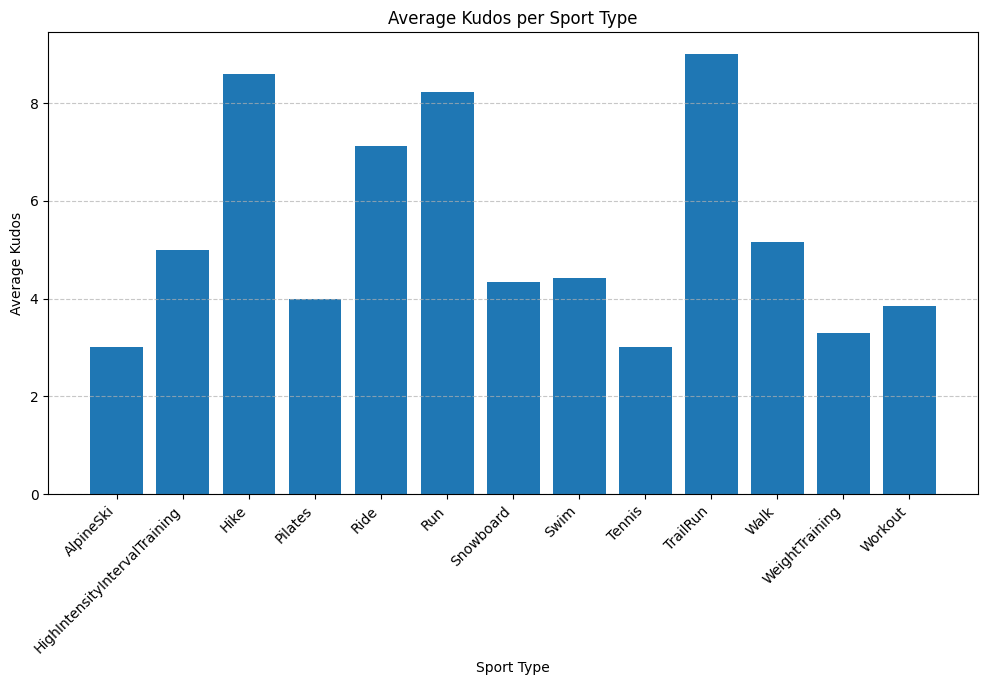

In [86]:
import matplotlib.pyplot as plt

# Compute average kudos per sport
average_kudos = data.groupby("sport_type")["kudos_count"].mean()

# Create a larger figure (width=12 inches, height=6 inches)
plt.figure(figsize=(12, 6))

# Plot the bar chart
plt.bar(average_kudos.index, average_kudos.values)

# Add labels and title
plt.xlabel("Sport Type")
plt.ylabel("Average Kudos")
plt.title("Average Kudos per Sport Type")

# Rotate x-axis labels if there are many or long names
plt.xticks(rotation=45, ha='right')

# Add grid for readability (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()


##Timeline

/tmp/ipython-input-3925012924.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['start_date'].dt.to_period('M').astype(str)


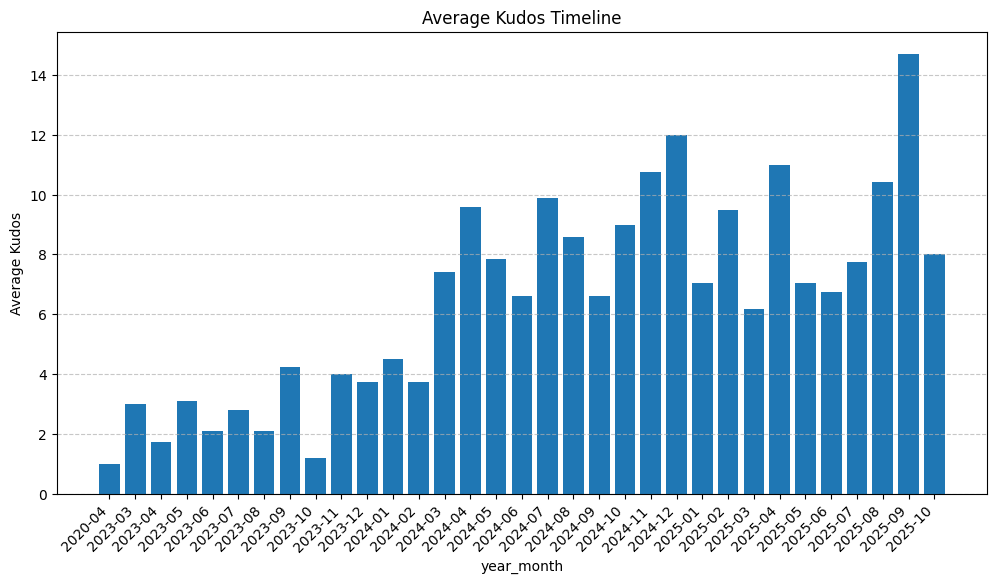

In [92]:
import matplotlib.pyplot as plt

data['year_month'] = data['start_date'].dt.to_period('M').astype(str)

# Compute average kudos per sport
average_kudos = data.groupby("year_month")["kudos_count"].mean()

# Create a larger figure (width=12 inches, height=6 inches)
plt.figure(figsize=(12, 6))

# Plot the bar chart
plt.bar(average_kudos.index, average_kudos.values)

# Add labels and title
plt.xlabel("year_month")
plt.ylabel("Average Kudos")
plt.title("Average Kudos Timeline")

# Rotate x-axis labels if there are many or long names
plt.xticks(rotation=45, ha='right')

# Add grid for readability (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()


#Moving Time Timeline

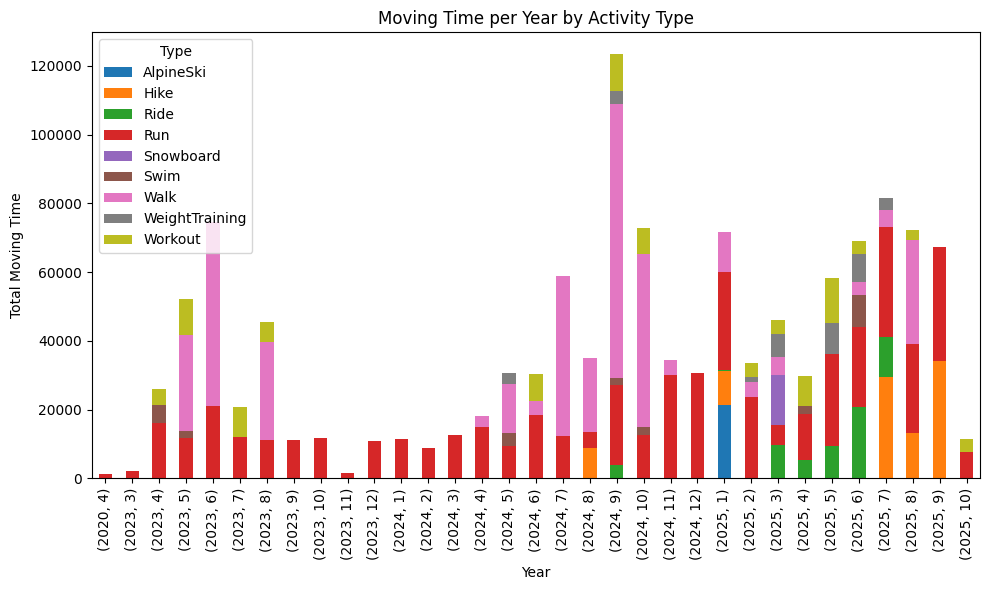

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Example assumes your DataFrame has at least these columns:
# 'Month', 'distance', and 'type'

# 1️⃣ Group data by Month and Type, summing distance
grouped = data.groupby(["Year", "Month", "type"])["moving_time"].sum().unstack(fill_value=0)

# 2️⃣ Plot stacked bar chart
grouped.plot(kind="bar", stacked=True, figsize=(10,6))

# 3️⃣ Customize chart
plt.title("Moving Time per Year by Activity Type")
plt.xlabel("Year")
plt.ylabel("Total Moving Time")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


#Condition Progress

/tmp/ipython-input-4193770182.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['start_date'].dt.to_period('M').astype(str)


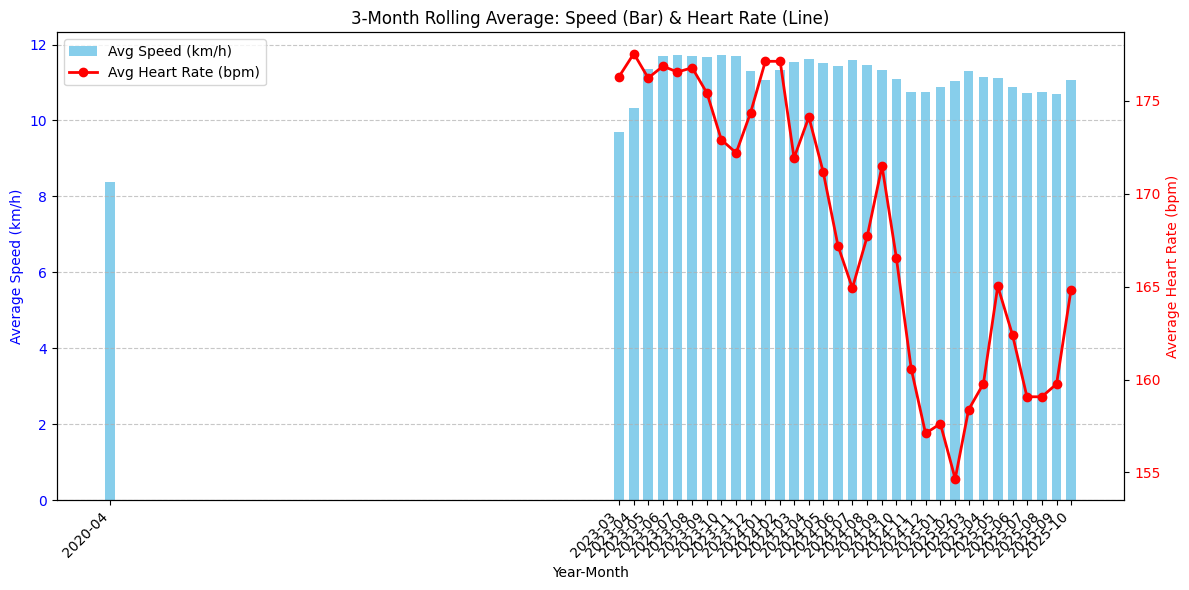

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Ensure date formatting ---
data['start_date'] = pd.to_datetime(data['start_date'])
data['year_month'] = data['start_date'].dt.to_period('M').astype(str)

# --- Aggregate by month ---
avg_hr = data[data["sport_type"] == "Run"].groupby("year_month")["average_heartrate"].mean()
avg_speed = data[data["sport_type"] == "Run"].groupby("year_month")["average_speed"].mean()*3.6 #to convert to km/h

# --- Combine both into one DataFrame ---
combined = pd.concat([avg_hr, avg_speed], axis=1)
combined.columns = ['average_heartrate', 'average_speed']

# --- Convert index to datetime for rolling calculation ---
combined.index = pd.to_datetime(combined.index)

# --- Apply 6-month rolling average ---
combined_rolled = combined.rolling(window=3, min_periods=1).mean()

# --- Create figure and dual axes ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Bar chart: Average Speed ---
ax1.bar(
    combined_rolled.index,
    combined_rolled['average_speed'],
    color='skyblue',
    width=20,          # widen bars (days)
    label='Avg Speed (km/h)'
)
ax1.set_xlabel("Year-Month")
ax1.set_ylabel("Average Speed (km/h)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Second axis: Line chart for Heart Rate ---
ax2 = ax1.twinx()
ax2.plot(
    combined_rolled.index,
    combined_rolled['average_heartrate'],
    color='red',
    marker='o',
    linewidth=2,
    label='Avg Heart Rate (bpm)'
)
ax2.set_ylabel("Average Heart Rate (bpm)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# --- Formatting ---
plt.title("3-Month Rolling Average: Speed (Bar) & Heart Rate (Line)")
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticks(combined_rolled.index)
ax1.set_xticklabels(combined_rolled.index.strftime('%Y-%m'), rotation=45, ha='right')

# --- Combine legends from both axes ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()




#Marathon Prediction

In [68]:
#check how many run activities i have on my strava app
data[data["type"] == "Run"].shape[0]

170

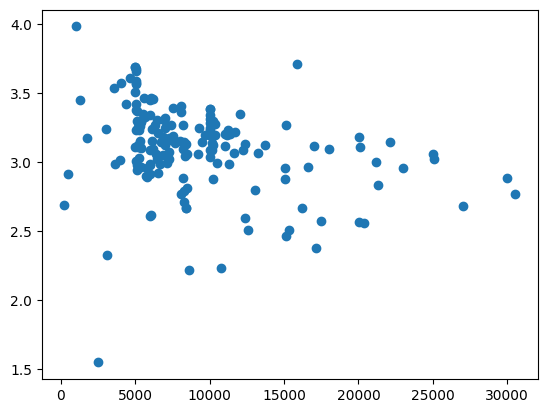

In [74]:
run_activities = data[data["type"] == "Run"]

activity_speed = run_activities["distance"] / run_activities["moving_time"]

plt.scatter(run_activities["distance"],activity_speed)

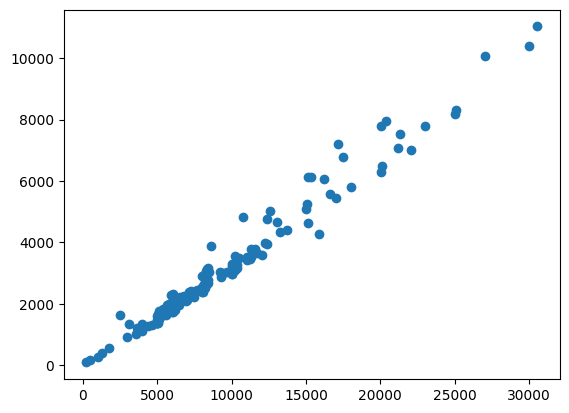

In [75]:
plt.scatter(run_activities["distance"], run_activities["moving_time"])